<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install ppscore
import ppscore as pps
from sklearn import linear_model
regr = linear_model.LinearRegression()
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import io
from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for ppscore: filename=ppscore-0.0.2-py2.py3-none-any.whl size=9629 sha256=715c0a8ccfc2ff64effb6f960c2b143f6d9acaf7b05b892ea5ce14dbea7210dd
  Stored in directory: /root/.cache/pip/wheels/29/32/a2/82782fc09f5cd68e401ff047201d38af8965fb94984db18aa5
Successfully built ppscore


Saving assumed_pha_thousand.csv to assumed_pha_thousand.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['assumed_pha_thousand.csv']))
df.fillna(df.median(),
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MID_POINT_X,MID_POINT_Y,Area,long,lat,Long_minus,Lat_minus
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442


X1             0.0
Y1             0.0
X2             0.0
Y2             0.0
MID_POINT_X    0.0
MID_POINT_Y    0.0
Area           0.0
long           0.0
lat            0.0
Long_minus     0.0
Lat_minus      0.0
dtype: float64


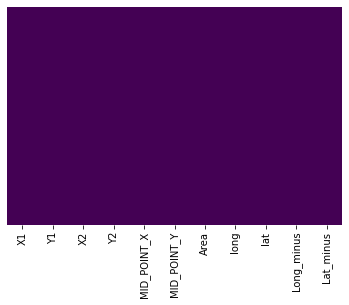

In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

# Blank plot shows non-missing values
sns.heatmap(df.isnull(), 
            yticklabels=False, 
            cbar=False, 
            cmap='viridis',)

In [4]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 11) Duplicated rows have been removed.


In [5]:
df.describe()

,X1,Y1,X2,Y2,MID_POINT_X,MID_POINT_Y,Area,long,lat,Long_minus,Lat_minus
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,717.111111,322.722222,750.888889,405.777778,734.000000,364.25000,3319.222222,24.920929,67.143501,833.833333,501.277778
std,342.164028,96.641122,331.976769,130.229009,337.006633,113.34438,3010.994980,0.000083,0.000162,279.634478,162.259344
min,215.000000,229.000000,258.000000,269.000000,239.500000,249.00000,680.000000,24.920807,67.143271,86.000000,271.000000
25%,373.750000,265.500000,434.250000,322.000000,404.000000,293.75000,1169.500000,24.920854,67.143336,832.000000,335.500000
50%,822.500000,289.000000,851.500000,364.000000,837.000000,326.50000,2329.000000,24.920930,67.143539,913.000000,539.000000
75%,961.750000,374.250000,981.000000,488.750000,971.250000,431.37500,4442.500000,24.921001,67.143600,995.250000,599.750000
max,1223.000000,548.000000,1256.000000,689.000000,1239.500000,618.50000,10366.000000,24.921052,67.143761,1052.000000,761.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X1           18 non-null     int64  
 1   Y1           18 non-null     int64  
 2   X2           18 non-null     int64  
 3   Y2           18 non-null     int64  
 4   MID_POINT_X  18 non-null     float64
 5   MID_POINT_Y  18 non-null     float64
 6   Area         18 non-null     int64  
 7   long         18 non-null     float64
 8   lat          18 non-null     float64
 9   Long_minus   18 non-null     int64  
 10  Lat_minus    18 non-null     int64  
dtypes: float64(4), int64(7)
memory usage: 1.7 KB


In [0]:
df.X1 = df.X1.astype('float64')
df.Y1 = df.Y1.astype('float64')
df.X2 = df.X2.astype('float64')
df.Y2 = df.Y2.astype('float64')
df.Area = df.Area.astype('float64')
df.Long_minus = df.Long_minus.astype('float64')
df.Lat_minus = df.Lat_minus.astype('float64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X1           18 non-null     float64
 1   Y1           18 non-null     float64
 2   X2           18 non-null     float64
 3   Y2           18 non-null     float64
 4   MID_POINT_X  18 non-null     float64
 5   MID_POINT_Y  18 non-null     float64
 6   Area         18 non-null     float64
 7   long         18 non-null     float64
 8   lat          18 non-null     float64
 9   Long_minus   18 non-null     float64
 10  Lat_minus    18 non-null     float64
dtypes: float64(11)
memory usage: 1.7 KB


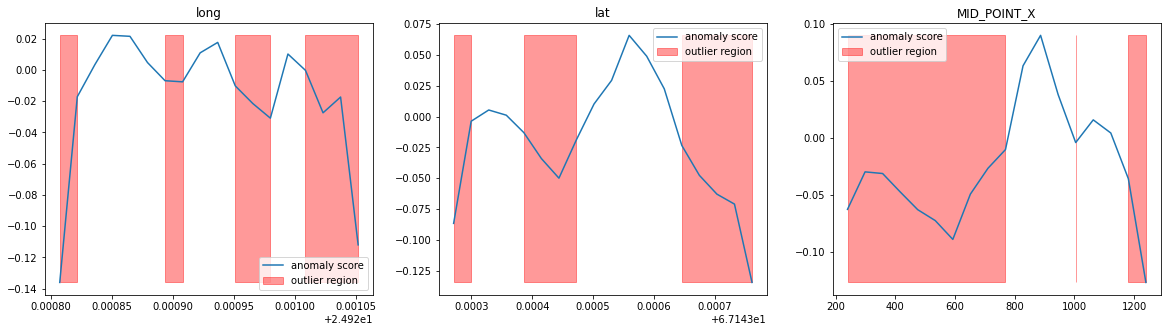

In [9]:
cols = ['long',
        'lat',
        'MID_POINT_X',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),
                        facecolor='w',
                        edgecolor='k',)
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(),
                     df[column].max(),
                     len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        np.min(anomaly_score),
                        np.max(anomaly_score), 
                     where=outlier==-1,
                     color='r', 
                     alpha=.4,
                     label='outlier region',)
    axs[i].legend()
    axs[i].set_title(column)

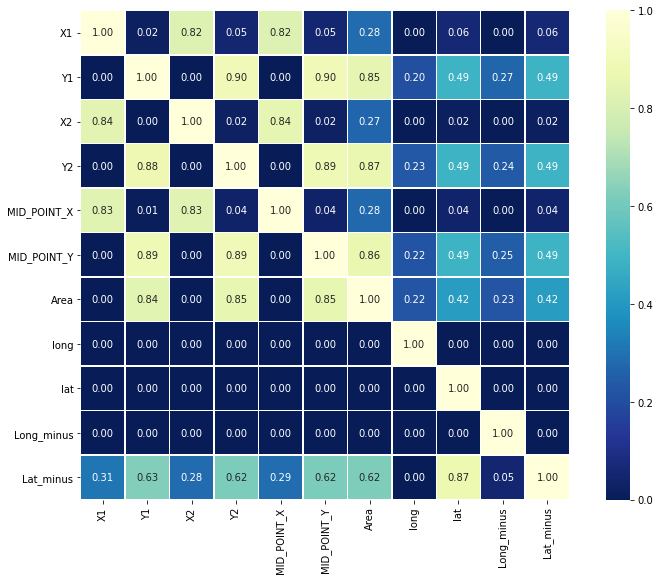

In [10]:
plt.figure(figsize=(13, 9))
sns.heatmap(pps.matrix(df),
            annot=True,
            fmt='.2f',
            square=True,
            cmap="YlGnBu_r",
            linewidths =.5,)

In [0]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)

In [12]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_df)
df_pca.shape

(18, 2)

In [13]:
pca.explained_variance_ratio_

array([0.73039592, 0.16044618])

In [14]:
any(df.long <= 0)

False

In [15]:
any(df.lat <= 0)

False

In [16]:
any(df.MID_POINT_X <= 0)

False

In [0]:
X = df[['long',
        'lat',]]
y = df['MID_POINT_X']

# Split the data into training/testing sets
X_train = X[:10]
X_test = X[10:]

# Split the targets into training/testing sets
y_train = y[:10]
y_test = y[10:]

In [18]:
X_train.head()

,long,lat
0,24.920860,67.143323
1,24.920899,67.143506
2,24.920841,67.143605
3,24.920933,67.143584
4,24.921013,67.143442


In [19]:
regr.fit(X_train,
         y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
y_pred = regr.predict(X_test)
print(X_test)
print(y_pred)

print('Coefficients: \n',
      regr.coef_,)

print('Mean squared error: %.2f'% mean_squared_error(y_test,
                                                     y_pred,))

print('Coefficient of determination: %.2f'
      % r2_score(y_test,
                 y_pred,))

         long        lat
10  24.921001  67.143343
11  24.920852  67.143563
12  24.920942  67.143555
13  24.921000  67.143724
14  24.920927  67.143555
15  24.920873  67.143292
16  24.920829  67.143271
17  24.920827  67.143284
[ 227.87995842 1094.80478472  851.56105649 1085.82962026  889.10798922
  433.77185991  496.7589329   530.95365497]
Coefficients: 
 [-2503128.84789164  2245266.49077892]
Mean squared error: 11856.89
Coefficient of determination: 0.90


In [21]:
regr.predict([[24.920925,
               67.143550,]])

array([882.88791445])